<a href="https://colab.research.google.com/github/SiyumiJayawardhane/CustomerSubscriptionPrediction/blob/main/ModelBuilding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
import joblib

**1. Load Data**

In [3]:
# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/ML/Machine Learning Course Work/bank-additional-full.csv', sep=';')

In [4]:
#Display information
print("Dataset Info:")
print(data.info())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   4

In [5]:
#Load 5 rows
print("\nFirst 5 rows:")
print(data.head())


First 5 rows:
   age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon  ...         1    999         0  nonexistent          1.1   
1   may         mon  ...         1    999         0  nonexistent          1.1   
2   may         mon  ...         1    999         0  nonexistent          1.1   
3   may         mon  ...         1    999         0  nonexistent          1.1   
4   may         mon  ...         1    999         0  nonexistent          1.1   

   cons.price.idx  cons.conf.idx  euribor

**2. Data preprocessing**

In [6]:
# Encode categorical variables
categorical_columns = data.select_dtypes(include=['object']).columns
for column in categorical_columns:
    if column != 'y':
        le = LabelEncoder()
        data[column] = le.fit_transform(data[column])

In [7]:
# Map target variable to binary
data['y'] = data['y'].map({'yes': 1, 'no': 0})

**3. Correlation Analysis**

In [8]:
print("\nCorrelation Analysis:")
correlation_matrix = data.corr()
correlation_with_target = correlation_matrix['y'].sort_values(ascending=False)
print(correlation_with_target)


Correlation Analysis:
y                 1.000000
duration          0.405274
previous          0.230181
poutcome          0.129789
education         0.057799
cons.conf.idx     0.054878
marital           0.046203
age               0.030399
job               0.025122
day_of_week       0.015967
housing           0.011552
loan             -0.004909
month            -0.006065
campaign         -0.066357
default          -0.099352
cons.price.idx   -0.136211
contact          -0.144773
emp.var.rate     -0.298334
euribor3m        -0.307771
pdays            -0.324914
nr.employed      -0.354678
Name: y, dtype: float64


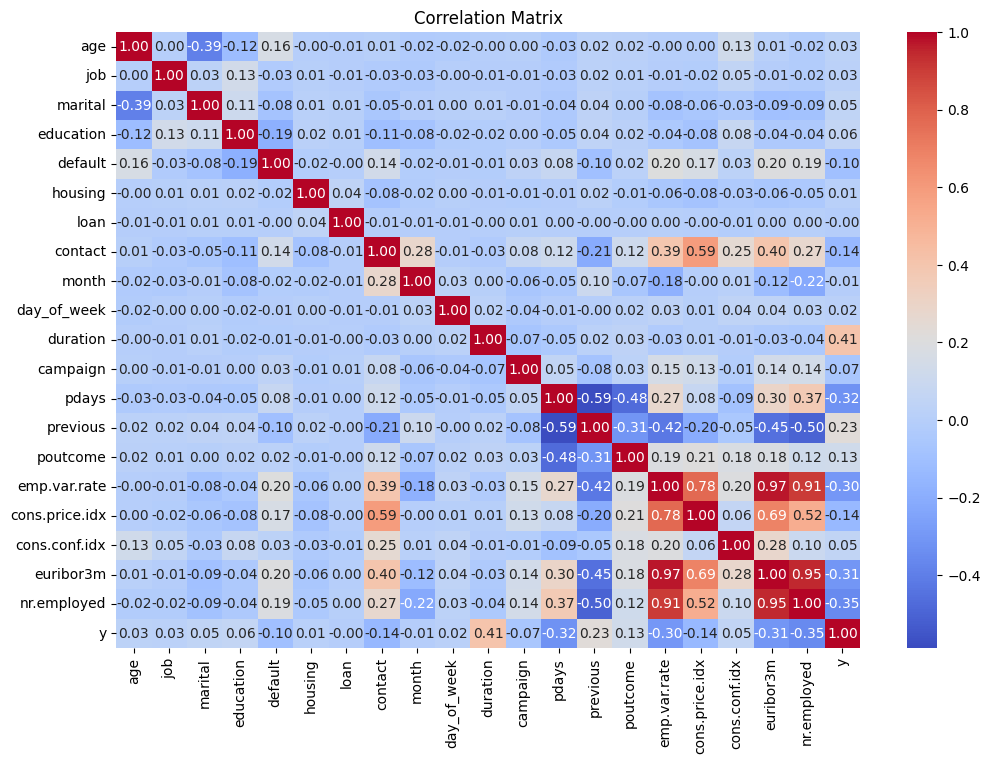

In [12]:
# Visualize correlation with a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [13]:
# Drop features with very low correlation
low_correlation_features = correlation_with_target[correlation_with_target.abs() < 0.05].index
print(f"\nDropping low-correlation features: {list(low_correlation_features)}")
data = data.drop(columns=low_correlation_features)


Dropping low-correlation features: ['marital', 'age', 'job', 'day_of_week', 'housing', 'loan', 'month']


In [14]:
# Separate features and target
X = data.drop('y', axis=1)
y = data['y']

**4. Handle data imbalance using SMOTE**

In [23]:
print("\nHandling class imbalance with SMOTE...")
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


Handling class imbalance with SMOTE...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [24]:
# Scale numerical features
scaler = StandardScaler()
X_resampled_scaled = scaler.fit_transform(X_resampled)

In [25]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled_scaled, y_resampled, test_size=0.2, random_state=42
)

 **5. Random Forest Classifier**

In [26]:
print("\nTraining Random Forest Classifier...")
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)


Training Random Forest Classifier...


In [27]:
# Evaluate Random Forest
print("\nRandom Forest Performance:")
print(classification_report(y_test, rf_predictions))
print(f"AUC-ROC Score: {roc_auc_score(y_test, rf_predictions):.2f}")


Random Forest Performance:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      7332
           1       0.93      0.96      0.94      7288

    accuracy                           0.94     14620
   macro avg       0.94      0.94      0.94     14620
weighted avg       0.94      0.94      0.94     14620

AUC-ROC Score: 0.94


**6. Neural Network Classifier**

In [28]:
print("\nTraining Neural Network Classifier...")
nn_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])


Training Neural Network Classifier...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [29]:
# Compile the Neural Network model
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [30]:
# Calculate class weights
class_weights = {0: len(y_resampled) / (2 * sum(y_resampled == 0)),
                 1: len(y_resampled) / (2 * sum(y_resampled == 1))}

In [32]:
# Train the Neural Network model
y_train = y_train.reset_index(drop=True)  # Reset index to 0, 1, 2...
history = nn_model.fit(
    X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1, class_weight=class_weights
)

Epoch 1/50
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8471 - loss: 0.3493 - val_accuracy: 0.8869 - val_loss: 0.2654
Epoch 2/50
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8884 - loss: 0.2711 - val_accuracy: 0.8945 - val_loss: 0.2491
Epoch 3/50
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8964 - loss: 0.2529 - val_accuracy: 0.9027 - val_loss: 0.2371
Epoch 4/50
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8995 - loss: 0.2427 - val_accuracy: 0.9043 - val_loss: 0.2332
Epoch 5/50
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9020 - loss: 0.2419 - val_accuracy: 0.9054 - val_loss: 0.2299
Epoch 6/50
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9027 - loss: 0.2381 - val_accuracy: 0.9061 - val_loss: 0.2299
Epoch 7/50
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9047 - loss: 0.2345 - val_accuracy: 0.9064 - val_loss: 0.2281
Epoch 8/50
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9032 - loss: 0.2385 - 

In [33]:
# Evaluate Neural Network
nn_predictions = (nn_model.predict(X_test) > 0.5).astype(int).flatten()
print("\nNeural Network Performance:")
print(classification_report(y_test, nn_predictions))
print(f"AUC-ROC Score: {roc_auc_score(y_test, nn_predictions):.2f}")

457/457 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Neural Network Performance:
              precision    recall  f1-score   support

           0       0.94      0.89      0.91      7332
           1       0.89      0.94      0.92      7288

    accuracy                           0.91     14620
   macro avg       0.92      0.91      0.91     14620
weighted avg       0.92      0.91      0.91     14620

AUC-ROC Score: 0.91


**7. Save Results**

In [36]:
# Save Random Forest Model
joblib.dump(rf_model, "random_forest_model.pkl")

['random_forest_model.pkl']

In [37]:
# Save Neural Network Model
nn_model.save("neural_network_model.h5")

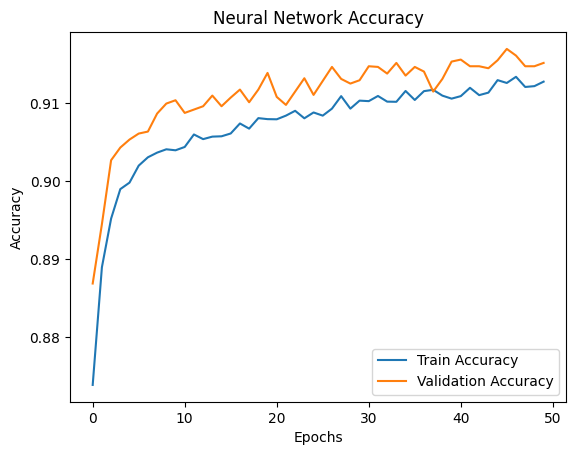

In [38]:
# Plot Neural Network Training History
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Neural Network Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()